In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [2]:
# Load dataset
ratings_path = "ml-latest-small/ratings.csv"
ratings = pd.read_csv(ratings_path)

In [3]:
# Identify actual min and max ratings
min_rating = ratings['rating'].min()
max_rating = ratings['rating'].max()
print(f"Min rating: {min_rating}, Max rating: {max_rating}")

Min rating: 0.5, Max rating: 5.0


In [4]:
# Normalize ratings based on actual range
ratings['normalized_rating'] = ratings['rating'].apply(
    lambda x: (x - min_rating) / (max_rating - min_rating) if x > 0 else 0
)

In [5]:
# Map userId and movieId to consecutive indices
user_mapping = {user_id: idx for idx, user_id in enumerate(ratings['userId'].unique())}
movie_mapping = {movie_id: idx for idx, movie_id in enumerate(ratings['movieId'].unique())}

ratings['userId'] = ratings['userId'].map(user_mapping)
ratings['movieId'] = ratings['movieId'].map(movie_mapping)

# Number of users and movies
num_users = len(user_mapping)
num_movies = len(movie_mapping)
print(f"Number of users: {num_users}")
print(f"Number of movies: {num_movies}")

Number of users: 610
Number of movies: 9724


In [6]:
# Create user-item interaction matrix
user_item_matrix = torch.zeros((num_users, num_movies))

# Populate user-item interaction matrix
for row in ratings.itertuples():
    user_item_matrix[row.userId, row.movieId] = row.normalized_rating

In [7]:
user_item_matrix

tensor([[0.7778, 0.7778, 0.7778,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        ...,
        [0.4444, 0.3333, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [0.5556, 0.0000, 0.0000,  ..., 0.0000, 0.0000, 0.0000],
        [1.0000, 0.0000, 1.0000,  ..., 0.5556, 0.6667, 0.6667]])

In [8]:
# Split users into train/val and test groups
users = ratings['userId'].unique()
train_val_users, test_users = train_test_split(users, test_size=0.2, random_state=77)

# Create train/val and test dataframes based on the user split
train_val_data = ratings[ratings['userId'].isin(train_val_users)].reset_index(drop=True)
test_data = ratings[ratings['userId'].isin(test_users)].reset_index(drop=True)

print(f"Train/Val Data Size: {train_val_data.shape[0]}")
print(f"Test Data Size: {test_data.shape[0]}")

Train/Val Data Size: 82140
Test Data Size: 18696


In [9]:
# Train/Val Matrix: Only for train_val_users
train_val_matrix = torch.zeros((len(train_val_users), num_movies))

# Test Matrix: Only for test_users
test_matrix = torch.zeros((len(test_users), num_movies))

# Populate train/val and test matrices
train_val_user_mapping = {u: i for i, u in enumerate(train_val_users)}
test_user_mapping = {u: i for i, u in enumerate(test_users)}

for row in train_val_data.itertuples():
    user_idx = train_val_user_mapping[row.userId]
    train_val_matrix[user_idx, row.movieId] = row.normalized_rating

for row in test_data.itertuples():
    user_idx = test_user_mapping[row.userId]
    test_matrix[user_idx, row.movieId] = row.normalized_rating

print("Train/Val and Test matrices populated.")

Train/Val and Test matrices populated.


In [10]:
total_entries = num_users * num_movies

non_zero_entries = ratings.shape[0]

sparsity = (1 - (non_zero_entries / total_entries)) * 100

print(f"User-Item Matrix Sparsity: {sparsity:.2f}%")

User-Item Matrix Sparsity: 98.30%


# Data augmentation

Worsen's the performance, because data sparsity is 98+%

In [11]:
# def impute_with_item_averages(matrix):
#     # Compute average rating for each movie (ignoring zeros)
#     item_avg_ratings = torch.sum(matrix, dim=0) / (torch.sum(matrix > 0, dim=0) + 1e-8)

#     # Create a mask for missing ratings (zeros in the matrix)
#     missing_mask = matrix == 0

#     # Broadcast item_avg_ratings to the entire matrix and apply only to missing values
#     item_avg_matrix = item_avg_ratings.unsqueeze(0).expand_as(matrix)  # Expand to match matrix dimensions
#     matrix[missing_mask] = item_avg_matrix[missing_mask]  # Fill missing values with item averages

#     return matrix

# # Apply imputation to train_val_matrix and test_matrix
# train_val_matrix = impute_with_item_averages(train_val_matrix)
# test_matrix = impute_with_item_averages(test_matrix)


# # Final Matrix Shapes
# print(f"Train/Val Matrix Shape: {train_val_matrix.shape}")
# print(f"Test Matrix Shape: {test_matrix.shape}")

In [12]:
user_item_matrix.shape

torch.Size([610, 9724])

In [13]:
test_data

,userId,movieId,rating,timestamp,normalized_rating
0,2,259,0.5,1306463578,0.000000
1,2,28,0.5,1306464275,0.000000
2,2,260,0.5,1306463619,0.000000
3,2,261,0.5,1306464228,0.000000
4,2,262,0.5,1306463595,0.000000
...,...,...,...,...,...
18691,602,5359,1.0,1002403253,0.111111
18692,602,3322,1.0,1002403269,0.111111
18693,602,2122,4.0,1002403400,0.777778
18694,602,231,3.0,953926877,0.555556


In [14]:
train_matrix, val_matrix = train_test_split(train_val_matrix, test_size=0.2, random_state=78)

In [15]:
test_data.shape

(18696, 5)

In [16]:
train_val_matrix.shape

torch.Size([488, 9724])

In [17]:
test_matrix.shape

torch.Size([122, 9724])

In [18]:
val_matrix.shape

torch.Size([98, 9724])

In [19]:
class AutoRecSig(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, p=0.2):
        super(AutoRecSig, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        encoded = self.dropout(self.sigmoid(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [20]:
class AutoRecTan(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, p=0.2):
        super(AutoRecTan, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.tanh = nn.Tanh()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        encoded = self.dropout(self.tanh(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [21]:
class AutoRecRel(nn.Module):
    def __init__(self, num_items, hidden_dim, lambda_, p=0.2):
        super(AutoRecRel, self).__init__()
        self.lambda_ = lambda_
        self.encoder = nn.Linear(num_items, hidden_dim, bias=True)
        self.decoder = nn.Linear(hidden_dim, num_items, bias=True)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        encoded = self.dropout(self.relu(self.encoder(x)))
        decoded = self.decoder(encoded)
        return decoded

    def regularization_loss(self):
        reg_loss = 0
        for param in self.parameters():
            reg_loss += param.norm(2)
        return self.lambda_ * reg_loss

In [22]:
def train_epoch(model, train_data, optimizer, criterion, batch_size):
    model.train()
    num_batches = train_data.size(0) // batch_size
    total_loss = 0

    for i in range(num_batches):
        batch = train_data[i * batch_size:(i + 1) * batch_size].to(device)

        optimizer.zero_grad()
        predictions = model(batch)
        mask = batch > 0 
        loss = criterion(predictions[mask], batch[mask]) + model.regularization_loss()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    return total_loss / num_batches


In [23]:
def evaluate_model(model, test_data, criterion, batch_size):
    model.eval()
    num_batches = test_data.size(0) // batch_size
    total_loss = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = test_data[i * batch_size:(i + 1) * batch_size].to(device)

            predictions = model(batch)
            mask = (batch > 0).to(device)
            loss = criterion(predictions[mask], batch[mask])
            total_loss += loss.item()

    return total_loss / num_batches

In [24]:
# Hyperparameters
hidden_dim = 100
lambda_ = 0.001
learning_rate = 0.0001
batch_size = 32
epochs = 150
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [25]:
# Initialize model, optimizer, and loss function
model = AutoRecSig(num_movies, hidden_dim, lambda_).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=5e-4)
criterion = nn.MSELoss()

In [26]:
train_tensor = train_matrix.to(device)
test_tensor = test_matrix.to(device)
val_tensor = val_matrix.to(device)

In [27]:
train_losses, val_losses = [], []

In [28]:
for epoch in range(epochs):
    train_loss = train_epoch(model, train_tensor, optimizer, criterion, batch_size)
    val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    
    print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")

Epoch 1/150, Train Loss: 0.6503, Validation Loss: 0.5433
Epoch 2/150, Train Loss: 0.5809, Validation Loss: 0.4888
Epoch 3/150, Train Loss: 0.5317, Validation Loss: 0.4453
Epoch 4/150, Train Loss: 0.4925, Validation Loss: 0.4068
Epoch 5/150, Train Loss: 0.4587, Validation Loss: 0.3702
Epoch 6/150, Train Loss: 0.4232, Validation Loss: 0.3348
Epoch 7/150, Train Loss: 0.3908, Validation Loss: 0.3008
Epoch 8/150, Train Loss: 0.3587, Validation Loss: 0.2688
Epoch 9/150, Train Loss: 0.3278, Validation Loss: 0.2395
Epoch 10/150, Train Loss: 0.3015, Validation Loss: 0.2135
Epoch 11/150, Train Loss: 0.2772, Validation Loss: 0.1909
Epoch 12/150, Train Loss: 0.2559, Validation Loss: 0.1712
Epoch 13/150, Train Loss: 0.2389, Validation Loss: 0.1545
Epoch 14/150, Train Loss: 0.2219, Validation Loss: 0.1406
Epoch 15/150, Train Loss: 0.2101, Validation Loss: 0.1287
Epoch 16/150, Train Loss: 0.1968, Validation Loss: 0.1191
Epoch 17/150, Train Loss: 0.1868, Validation Loss: 0.1111
Epoch 18/150, Train Los

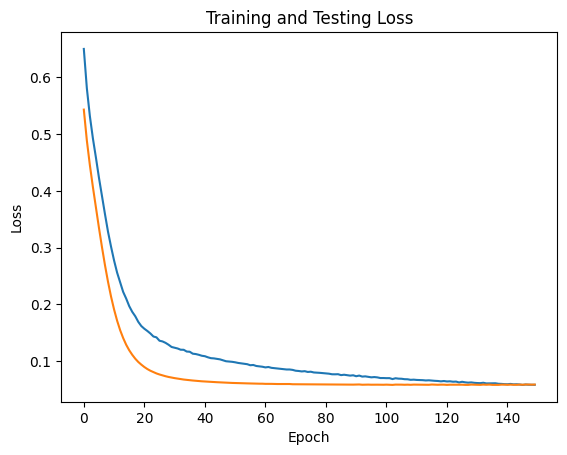

In [29]:
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.show()

In [30]:
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

In [31]:
rmse = calculate_rmse(model, test_tensor, batch_size)
print(f"Test RMSE: {rmse:.4f}")

Test RMSE: 0.2619


In [32]:
import numpy as np
import torch
from torch import nn

# Calculate RMSE
def calculate_rmse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return np.sqrt(mse / total_ratings)

# Calculate MAE
def calculate_mae(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mae = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mae += (predictions[mask] - batch[mask]).abs().sum().item()
            total_ratings += mask.sum().item()

    return mae / total_ratings

# Calculate MSE
def calculate_mse(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    mse = 0
    total_ratings = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0
            
            mse += ((predictions[mask] - batch[mask]) ** 2).sum().item()
            total_ratings += mask.sum().item()

    return mse / total_ratings

# Calculate R-Squared
def calculate_r2(model, data, batch_size):
    model.eval()
    num_batches = data.size(0) // batch_size
    ss_total = 0
    ss_residual = 0

    with torch.no_grad():
        for i in range(num_batches):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0

            mean_rating = batch[mask].mean().item()
            ss_total += ((batch[mask] - mean_rating) ** 2).sum().item()
            ss_residual += ((predictions[mask] - batch[mask]) ** 2).sum().item()

    return 1 - (ss_residual / ss_total)

# Calculate Explained Variance
def calculate_explained_variance(model, data, batch_size):
    model.eval()
    variance_explained = 0
    variance_total = 0

    with torch.no_grad():
        for i in range(data.size(0) // batch_size):
            batch = data[i * batch_size:(i + 1) * batch_size].to(device)
            predictions = model(batch)
            mask = batch > 0

            batch_var = ((batch[mask] - batch[mask].mean()) ** 2).sum().item()
            residual_var = ((batch[mask] - predictions[mask]) ** 2).sum().item()

            variance_total += batch_var
            variance_explained += (batch_var - residual_var)

    return variance_explained / variance_total

In [33]:
batch_size = 32

rmse = calculate_rmse(model, test_tensor, batch_size)
mae = calculate_mae(model, test_tensor, batch_size)
mse = calculate_mse(model, test_tensor, batch_size)
r2 = calculate_r2(model, test_tensor, batch_size)
explained_variance = calculate_explained_variance(model, test_tensor, batch_size)

print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test R2: {r2:.4f}")
print(f"Test Explained Variance: {explained_variance:.4f}")

Test RMSE: 0.2619
Test MAE: 0.1920
Test MSE: 0.0686
Test R2: -0.5060
Test Explained Variance: -0.5060


In [34]:
# Define the test function for a single test user
def test_model_top_k_masking_single_user_with_test_matrix(
    model, user_id, test_matrix, test_user_mapping, k=5
):
    model.eval()

    # Get the user index from the test user mapping
    if user_id not in test_user_mapping:
        raise ValueError(f"User ID {user_id} not found in test user mapping.")

    user_idx = test_user_mapping[user_id]
    
    # Get the user's ratings from the test matrix
    user_ratings = test_matrix[user_idx].clone()
    
    # Identify the top-K movies rated by the user
    sorted_indices = torch.argsort(user_ratings, descending=True)
    top_k_indices = sorted_indices[:k]
    
    # Save the actual values for the top-K movies
    real_values = user_ratings[top_k_indices].tolist()
    
    # Mask the top-K ratings in the matrix
    masked_ratings = user_ratings.clone()
    masked_ratings[top_k_indices] = 0  # Set top-K ratings to 0 for prediction

    # Predict ratings for all movies
    predicted_ratings = model(masked_ratings.unsqueeze(0).to(device)).squeeze(0).cpu()
    
    # Retrieve predictions for the masked movies
    predicted_values = predicted_ratings[top_k_indices].tolist()

    # Calculate hits (correct predictions)
    threshold = min(real_values)  # Use the lowest rating among the top-K as the threshold
    predicted_set = torch.argsort(predicted_ratings, descending=True)[:k].tolist()
    hits = sum(1 for idx in top_k_indices if idx in predicted_set)
    # print(top_k_indices)
    # print(predicted_set)
    accuracy = hits / k

    # Compute evaluation metrics
    rmse = torch.sqrt(torch.mean((torch.tensor(predicted_values) - torch.tensor(real_values)) ** 2)).item()
    mae = torch.mean(torch.abs(torch.tensor(predicted_values) - torch.tensor(real_values))).item()

    return {
        "Accuracy": accuracy * 100,  # Convert to percentage
        "Hits": hits,
        "Total Masked": k,
    }

In [35]:
# Define the test function for all test users
def test_model_top_k_masking_with_users(model, test_users, test_matrix, test_user_mapping, k=5):
    all_metrics = []
    for user_id in test_users:
        metrics = test_model_top_k_masking_single_user_with_test_matrix(
            model, user_id, test_matrix, test_user_mapping, k=k
        )
        all_metrics.append(metrics)

    avg_accuracy = sum(m["Accuracy"] for m in all_metrics) / len(all_metrics)

    return {
        "Average Accuracy": avg_accuracy,
        "Total Users": len(all_metrics),
    }


In [36]:
# Evaluate the model on the test users
metrics = test_model_top_k_masking_with_users(model, test_users, test_matrix, test_user_mapping, k=10)

# Print the results
print(f"Average Accuracy: {metrics['Average Accuracy']:.2f}%")
print(f"Total Test Users: {metrics['Total Users']}")

Average Accuracy: 5.25%
Total Test Users: 122


# Choosing hyperparameters



In [32]:
# import itertools
# from sklearn.model_selection import KFold
# import numpy as np
# import torch
# from torch import nn

# # Define hyperparameter grid
# param_grid = {
#     'hidden_dim': [50, 100, 200],
#     'lambda_': [0.0001, 0.001, 0.01],
#     'learning_rate': [0.001, 0.0001, 0.00001],
#     'batch_size': [32, 64, 128],
# }

# param_combinations = list(itertools.product(*param_grid.values()))

# # Define K-Fold Cross-Validation
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Function to train and evaluate using K-Fold Cross-Validation
# def train_and_evaluate_kfold(params, full_matrix, k_folds):
#     # Unpack parameters
#     hidden_dim, lambda_, learning_rate, batch_size= params

#     # Initialize storage for RMSE scores
#     fold_rmse_scores = []

#     # Perform K-Fold Cross-Validation
#     for train_idx, val_idx in kf.split(full_matrix):
#         # Create train and validation matrices
#         train_matrix = torch.zeros_like(full_matrix)
#         val_matrix = torch.zeros_like(full_matrix)
        
#         # Populate train and validation matrices
#         train_matrix[train_idx] = full_matrix[train_idx]
#         val_matrix[val_idx] = full_matrix[val_idx]
        
#         # Initialize model, optimizer, and loss function
#         model = AutoRecRel(num_movies, hidden_dim, lambda_).to(device)
#         optimizer = torch.optim.Adam(
#             model.parameters(),
#             lr=learning_rate,
#         )
#         criterion = nn.MSELoss()

#         # Train the model
#         train_tensor = train_matrix.to(device)
#         val_tensor = val_matrix.to(device)
#         for epoch in range(100):  # Fewer epochs for faster cross-validation
#             train_epoch(model, train_tensor, optimizer, criterion, batch_size)

#             # Evaluate the model on the validation set after each epoch
#             val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

#         # Final evaluation for this fold
#         rmse = calculate_rmse(model, val_tensor, batch_size)
#         fold_rmse_scores.append(rmse)

#     # Return the average RMSE across all folds
#     return np.mean(fold_rmse_scores)

# # Track best hyperparameters and performance
# best_params = None
# best_rmse = float('inf')

# # Perform hyperparameter search
# for i, params in enumerate(param_combinations):
#     print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
#     rmse = train_and_evaluate_kfold(params, user_item_matrix, k_folds)

#     print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

#     # Update best parameters if current RMSE is better
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = params

# # Print the best hyperparameters
# best_param_dict = dict(zip(param_grid.keys(), best_params))
# print(f"\nRelU Best Hyperparameters: {best_param_dict}")
# print(f"Best RMSE: {best_rmse:.4f}")


Testing combination 1/81: (50, 0.0001, 0.001, 32)
Average RMSE across 5 folds: 0.3002
Testing combination 2/81: (50, 0.0001, 0.001, 64)
Average RMSE across 5 folds: 0.3096
Testing combination 3/81: (50, 0.0001, 0.001, 128)
Average RMSE across 5 folds: 0.3260
Testing combination 4/81: (50, 0.0001, 0.0001, 32)
Average RMSE across 5 folds: 0.4221
Testing combination 5/81: (50, 0.0001, 0.0001, 64)
Average RMSE across 5 folds: 0.4667
Testing combination 6/81: (50, 0.0001, 0.0001, 128)
Average RMSE across 5 folds: 0.4854
Testing combination 7/81: (50, 0.0001, 1e-05, 32)
Average RMSE across 5 folds: 0.5258
Testing combination 8/81: (50, 0.0001, 1e-05, 64)
Average RMSE across 5 folds: 0.6259
Testing combination 9/81: (50, 0.0001, 1e-05, 128)
Average RMSE across 5 folds: 0.6852
Testing combination 10/81: (50, 0.001, 0.001, 32)
Average RMSE across 5 folds: 0.2948
Testing combination 11/81: (50, 0.001, 0.001, 64)
Average RMSE across 5 folds: 0.3096
Testing combination 12/81: (50, 0.001, 0.001, 12

In [33]:
# import itertools
# from sklearn.model_selection import KFold
# import numpy as np
# import torch
# from torch import nn

# # Define hyperparameter grid
# param_grid = {
#     'hidden_dim': [50, 100, 200],
#     'lambda_': [0.0001, 0.001, 0.01],
#     'learning_rate': [0.001, 0.0001, 0.00001],
#     'batch_size': [32, 64, 128],
# }

# param_combinations = list(itertools.product(*param_grid.values()))

# # Define K-Fold Cross-Validation
# k_folds = 5
# kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# # Function to train and evaluate using K-Fold Cross-Validation
# def train_and_evaluate_kfold(params, full_matrix, k_folds):
#     # Unpack parameters
#     hidden_dim, lambda_, learning_rate, batch_size= params

#     # Initialize storage for RMSE scores
#     fold_rmse_scores = []

#     # Perform K-Fold Cross-Validation
#     for train_idx, val_idx in kf.split(full_matrix):
#         # Create train and validation matrices
#         train_matrix = torch.zeros_like(full_matrix)
#         val_matrix = torch.zeros_like(full_matrix)
        
#         # Populate train and validation matrices
#         train_matrix[train_idx] = full_matrix[train_idx]
#         val_matrix[val_idx] = full_matrix[val_idx]
        
#         # Initialize model, optimizer, and loss function
#         model = AutoRecTan(num_movies, hidden_dim, lambda_).to(device)
#         optimizer = torch.optim.Adam(
#             model.parameters(),
#             lr=learning_rate,
#         )
#         criterion = nn.MSELoss()

#         # Train the model
#         train_tensor = train_matrix.to(device)
#         val_tensor = val_matrix.to(device)
#         for epoch in range(100):  # Fewer epochs for faster cross-validation
#             train_epoch(model, train_tensor, optimizer, criterion, batch_size)

#             # Evaluate the model on the validation set after each epoch
#             val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

#         # Final evaluation for this fold
#         rmse = calculate_rmse(model, val_tensor, batch_size)
#         fold_rmse_scores.append(rmse)

#     # Return the average RMSE across all folds
#     return np.mean(fold_rmse_scores)

# # Track best hyperparameters and performance
# best_params = None
# best_rmse = float('inf')

# # Perform hyperparameter search
# for i, params in enumerate(param_combinations):
#     print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
#     rmse = train_and_evaluate_kfold(params, user_item_matrix, k_folds)

#     print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

#     # Update best parameters if current RMSE is better
#     if rmse < best_rmse:
#         best_rmse = rmse
#         best_params = params

# # Print the best hyperparameters
# best_param_dict = dict(zip(param_grid.keys(), best_params))
# print(f"\nTanh Best Hyperparameters: {best_param_dict}")
# print(f"Best RMSE: {best_rmse:.4f}")


Testing combination 1/81: (50, 0.0001, 0.001, 32)
Average RMSE across 5 folds: 0.2834
Testing combination 2/81: (50, 0.0001, 0.001, 64)
Average RMSE across 5 folds: 0.2988
Testing combination 3/81: (50, 0.0001, 0.001, 128)
Average RMSE across 5 folds: 0.3312
Testing combination 4/81: (50, 0.0001, 0.0001, 32)
Average RMSE across 5 folds: 0.3410
Testing combination 5/81: (50, 0.0001, 0.0001, 64)
Average RMSE across 5 folds: 0.3534
Testing combination 6/81: (50, 0.0001, 0.0001, 128)
Average RMSE across 5 folds: 0.3564
Testing combination 7/81: (50, 0.0001, 1e-05, 32)
Average RMSE across 5 folds: 0.4954
Testing combination 8/81: (50, 0.0001, 1e-05, 64)
Average RMSE across 5 folds: 0.5986
Testing combination 9/81: (50, 0.0001, 1e-05, 128)
Average RMSE across 5 folds: 0.6758
Testing combination 10/81: (50, 0.001, 0.001, 32)
Average RMSE across 5 folds: 0.2806
Testing combination 11/81: (50, 0.001, 0.001, 64)
Average RMSE across 5 folds: 0.2961
Testing combination 12/81: (50, 0.001, 0.001, 12

In [59]:
import itertools
from sklearn.model_selection import KFold
import numpy as np
import torch
from torch import nn

# Define hyperparameter grid
param_grid = {
    'hidden_dim': [50, 100, 200],
    'lambda_': [0.0001, 0.001, 0.01],
    'learning_rate': [0.001, 0.0001, 0.00001],
    'batch_size': [32, 64, 128],
}

param_combinations = list(itertools.product(*param_grid.values()))

# Define K-Fold Cross-Validation
k_folds = 5
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# Function to train and evaluate using K-Fold Cross-Validation
def train_and_evaluate_kfold(params, full_matrix, k_folds):
    # Unpack parameters
    hidden_dim, lambda_, learning_rate, batch_size= params

    # Initialize storage for RMSE scores
    fold_rmse_scores = []

    # Perform K-Fold Cross-Validation
    for train_idx, val_idx in kf.split(full_matrix):
        # Create train and validation matrices
        train_matrix = torch.zeros_like(full_matrix)
        val_matrix = torch.zeros_like(full_matrix)
        
        # Populate train and validation matrices
        train_matrix[train_idx] = full_matrix[train_idx]
        val_matrix[val_idx] = full_matrix[val_idx]
        
        # Initialize model, optimizer, and loss function
        model = AutoRecSig(num_movies, hidden_dim, lambda_).to(device)
        optimizer = torch.optim.Adam(
            model.parameters(),
            lr=learning_rate,
        )
        criterion = nn.MSELoss()

        # Train the model
        train_tensor = train_matrix.to(device)
        val_tensor = val_matrix.to(device)
        for epoch in range(100):  # Fewer epochs for faster cross-validation
            train_epoch(model, train_tensor, optimizer, criterion, batch_size)

            # Evaluate the model on the validation set after each epoch
            val_loss = evaluate_model(model, val_tensor, criterion, batch_size)

        # Final evaluation for this fold
        rmse = calculate_rmse(model, val_tensor, batch_size)
        fold_rmse_scores.append(rmse)

    # Return the average RMSE across all folds
    return np.mean(fold_rmse_scores)

# Track best hyperparameters and performance
best_params = None
best_rmse = float('inf')

# Perform hyperparameter search
for i, params in enumerate(param_combinations):
    print(f"Testing combination {i+1}/{len(param_combinations)}: {params}")
    rmse = train_and_evaluate_kfold(params, user_item_matrix, k_folds)

    print(f"Average RMSE across {k_folds} folds: {rmse:.4f}")

    # Update best parameters if current RMSE is better
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = params

# Print the best hyperparameters
best_param_dict = dict(zip(param_grid.keys(), best_params))
print(f"\nSigmoid Best Hyperparameters: {best_param_dict}")
print(f"Best RMSE: {best_rmse:.4f}")


Testing combination 1/81: (50, 0.0001, 0.001, 32)


KeyboardInterrupt: 